In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Dolphin whistles vocalization

Source:
- 

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
import librosa

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
from glob import glob
import scipy.io as sio

In [7]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/5thworkshop2011//')

In [8]:
fg_list = list(DSLOC.glob('mat_structure_whisle_annotations/*/*.mat'))
mat_df = pd.DataFrame([[i.parent.stem, i, i.stem] for i in fg_list], columns = ['species', 'mfloc', 'stem'])
mat_df[:3]

species                                              mfloc  \
0  bottlenose  /mnt/cube/Datasets/mobysound/5thworkshop2011/m...   
1  bottlenose  /mnt/cube/Datasets/mobysound/5thworkshop2011/m...   
2  bottlenose  /mnt/cube/Datasets/mobysound/5thworkshop2011/m...   

                                 stem  
0    palmyra092007FS192-071012-010614  
1  ._palmyra092007FS192-071012-010614  
2      Qx-Tt-SCI0608-N1-060814-121518

In [9]:
wf_list = list(DSLOC.glob('*/*.wav'))
wf_list[:3]

[PosixPath('/mnt/cube/Datasets/mobysound/5thworkshop2011/5th_DCL_data_common/Qx-Dd-SCI0608-N1-060816-152609.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/5thworkshop2011/5th_DCL_data_common/Qx-Dd-SCI0608-N1-060815-122723.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/5thworkshop2011/5th_DCL_data_common/QX-Dc-FLIP0610-VLA-061015-164000.wav')]

In [10]:
wf_df = pd.DataFrame([[i, i.stem] for i in wf_list], columns = ['wf_loc', 'stem'])
wf_df[:3]

wf_loc  \
0  /mnt/cube/Datasets/mobysound/5thworkshop2011/5...   
1  /mnt/cube/Datasets/mobysound/5thworkshop2011/5...   
2  /mnt/cube/Datasets/mobysound/5thworkshop2011/5...   

                               stem  
0    Qx-Dd-SCI0608-N1-060816-152609  
1    Qx-Dd-SCI0608-N1-060815-122723  
2  QX-Dc-FLIP0610-VLA-061015-164000

### Create whistle df

In [11]:
tone_df = pd.DataFrame(columns=["species", "stem", "duration","snr", "freq", "phase", "time"])
for idx, row in tqdm(mat_df.iterrows(), total=len(mat_df)):
    # check is wf exists
    if len(wf_df[wf_df.stem == row.stem]) == 0:
        print("{} did not load".format(row.stem))
        continue
    try:
        mat_contents = sio.loadmat(row.mfloc)["filestruct"]
    except ValueError as e:
        print(row.stem, e)
        continue
    for tones in tqdm(mat_contents[0][0][0][0], leave=False):
        for tone in tones[0]:
            tone_duration, tone_snr, tone_freq, tone_phase, tone_time = tone
            tone_df.loc[len(tone_df)] = [
                row.species,
                row.stem,
                tone_duration.flatten(),
                tone_snr.flatten(),
                tone_freq.flatten(),
                tone_phase.flatten(),
                tone_time.flatten(),
            ]

._palmyra092007FS192-071012-010614 did not load


palmyra102006-061020-204454_4 did not load
palmyra102006-061020-204327_4 did not load
palmyra102006-061020-200922_1 did not load
palmyra092007FS192-070928-040000 did not load
palmyra092007FS192-071004-032000 did not load
palmyra092007FS192-070925-023000 did not load
palmyra092007FS192-070927-213444 did not load
palmyra092007FS192-071004-032342 did not load


Qx-Dc-CC0411-TAT11-CH2-041114-155040-s did not load


Qx-Dc-CC0411-TAT11-CH2-041114-154040-s did not load


In [12]:
min_freqs, max_freqs, mean_freqs, std_freq  = np.array([[np.min(i), np.max(i), np.mean(i), np.std(i)] for i in tone_df.freq.values]).T
freq_ranges = max_freqs - min_freqs

In [13]:
tone_df['min_freq'] = min_freqs
tone_df['max_freq'] = max_freqs
tone_df['mean_freq'] = mean_freqs
tone_df['freq_range'] = freq_ranges
tone_df['freq_std'] = std_freq

### quick look at whistle df

In [14]:
tone_df[:3]

species                              stem               duration  \
0  bottlenose  palmyra092007FS192-071012-010614  [0.22237569060773454]   
1  bottlenose  palmyra092007FS192-071012-010614   [0.1975138121546962]   
2  bottlenose  palmyra092007FS192-071012-010614  [0.40469613259668513]   

                                                 snr  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                freq  \
0  [10914.096916299563, 10893.548377475787, 10873...   
1  [7874.4493392070535, 7870.833978051172, 7867.2...   
2  [9592.511013215862, 9588.42360440496, 9584.347...   

                                               phase  \
0  <built-in method flatten of numpy.ndarray obje...   
1  <built-in method flatten of numpy.ndarray obje...   
2  <built-in method flatten of numpy.ndarray obje...   

                                                time     min_freq  \
0  [2.5628253038674034, 2.56340591924758, 2.56398...  8535.242291   
1  [2.8818860773480663, 2.882401779207478, 2.8829...  5825.991189   
2  [5.390173370165746, 5.391230018031534, 5.39228...  8403.083700   

       max_freq    mean_freq   freq_range    freq_std  
0  10914.096916  9289.987556  2378.854626  616.300312  
1   7874.449339  7039.716385  2048.458150  646.822227  
2   9592.511013  8971.748858  1189.427313  331.847616

In [15]:
len(tone_df)

11007

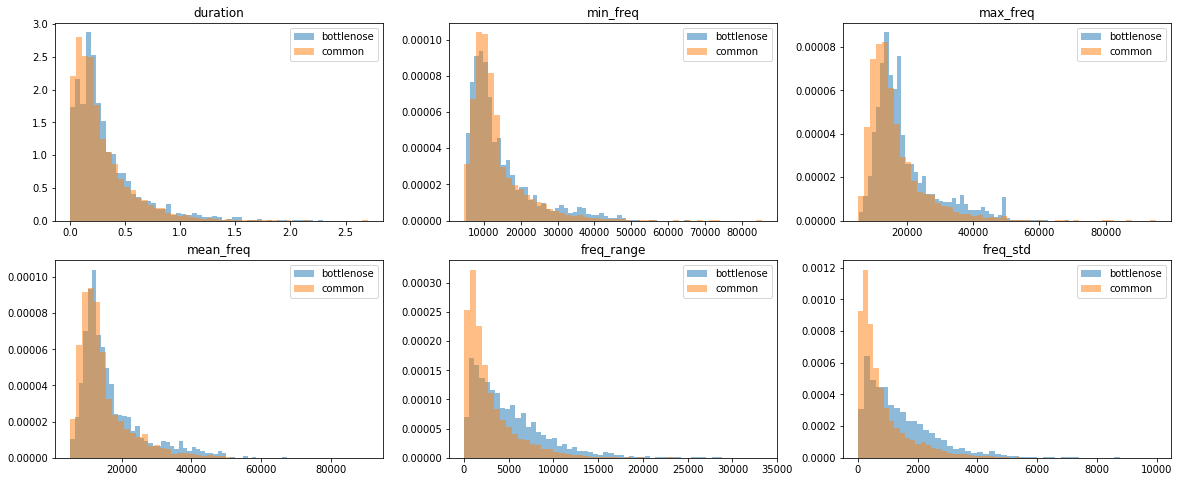

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
for tii, ti in enumerate(['duration', 'min_freq', 'max_freq', 'mean_freq', 'freq_range', 'freq_std']):
    ax = axs.flatten()[tii]
    for species in np.unique(tone_df.species):
        ax.hist(
            np.vstack(tone_df[tone_df.species == species][ti].values).flatten(),
            bins=50,
            alpha=0.5,
            label=species,
            density=True,
        )
    ax.legend()
    ax.set_title(ti)

In [17]:
import seaborn as sns

In [18]:
species = tone_df.species.unique()
cpal = sns.color_palette('Set1', len(species))
col_dict = {spec:cpal[i] for i, spec in enumerate(species)}
col_dict

{'bottlenose': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 'common': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)}

In [19]:
col_dict.values()

dict_values([(0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)])

In [20]:
from matplotlib.lines import Line2D

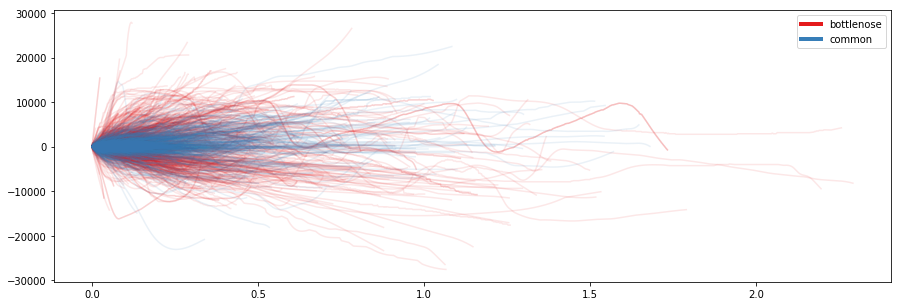

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
nex = 1000
for species in tone_df.species.unique():
    species_df = tone_df[tone_df.species == species]
    for ri in tqdm(range(nex), leave=False):
        row = species_df.iloc[np.random.randint(len(species_df))]
        ax.plot(row.time -row.time[0], row.freq.astype('float32')-row.freq[0], alpha = 0.1, color = col_dict[row.species])

custom_lines = [Line2D([0], [0], color=col, lw=4) for col in col_dict.values()]
ax.legend(custom_lines, col_dict.keys())             
plt.show()

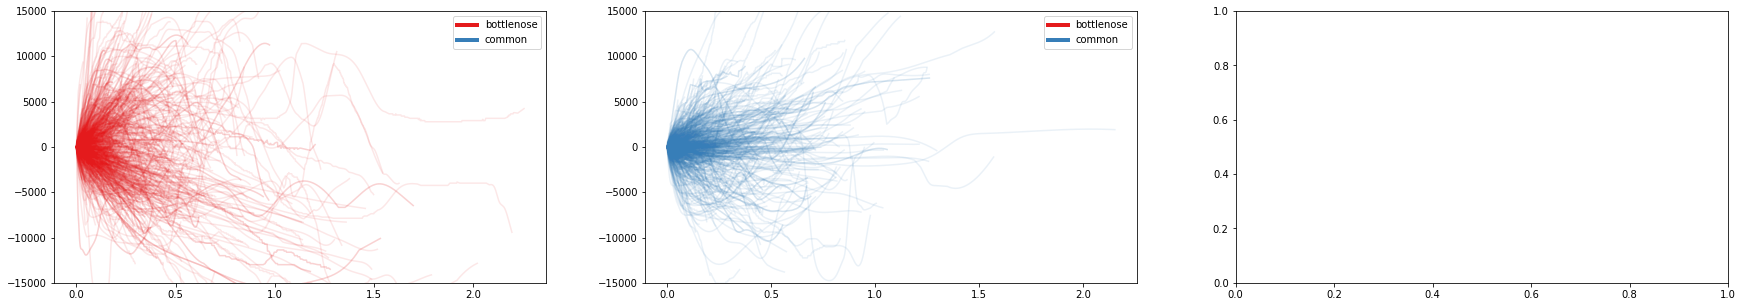

In [22]:
fig, axs = plt.subplots(ncols = 3, figsize=(30,5))
nex = 1000
for spci, species in enumerate(tone_df.species.unique()):
    ax = axs.flatten()[spci]
    species_df = tone_df[tone_df.species == species]
    for ri in tqdm(range(nex), leave=False):
        row = species_df.iloc[np.random.randint(len(species_df))]
        ax.plot(row.time -row.time[0], row.freq.astype('float32')-row.freq[0], alpha = 0.1, color = col_dict[row.species])
    ax.set_ylim([-15000, 15000])
    custom_lines = [Line2D([0], [0], color=col, lw=4) for col in col_dict.values()]
    ax.legend(custom_lines, col_dict.keys())             
plt.show()

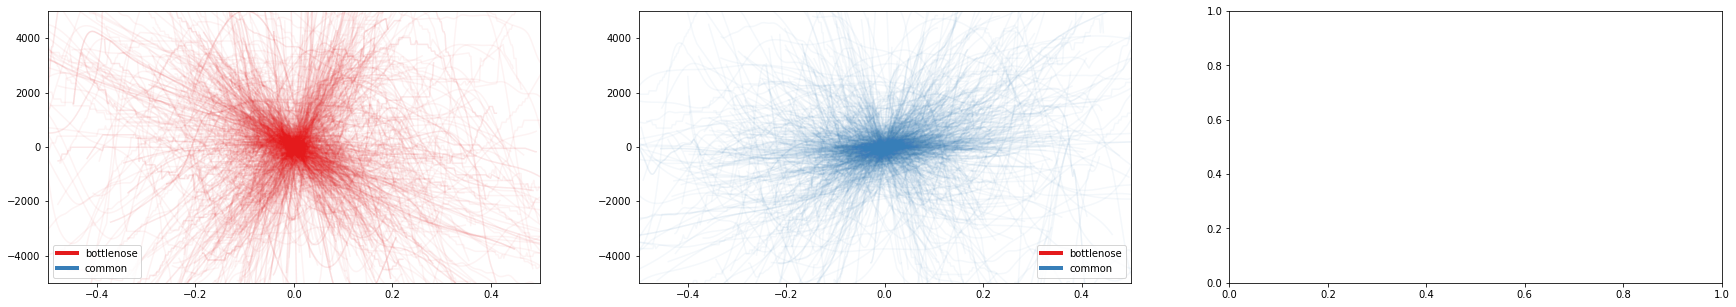

In [23]:
fig, axs = plt.subplots(ncols = 3, figsize=(30,5))
nex = 1000
for spci, species in enumerate(tone_df.species.unique()):
    ax = axs.flatten()[spci]
    species_df = tone_df[tone_df.species == species]
    for ri in tqdm(range(nex), leave=False):
        row = species_df.iloc[np.random.randint(len(species_df))]
        ax.plot(row.time -np.mean(row.time), row.freq.astype('float32')-np.mean(row.freq), alpha = 0.05, color = col_dict[row.species])
    ax.set_ylim([-5000, 5000])
    ax.set_xlim([-.5, .5])
    custom_lines = [Line2D([0], [0], color=col, lw=4) for col in col_dict.values()]
    ax.legend(custom_lines, col_dict.keys())             
plt.show()

### view audio

In [72]:
import librosa

In [84]:
time_padding = 0.5

In [115]:
win_length_ms = 10
hop_length_ms = 1
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

1920.0
192.0


bottlenose


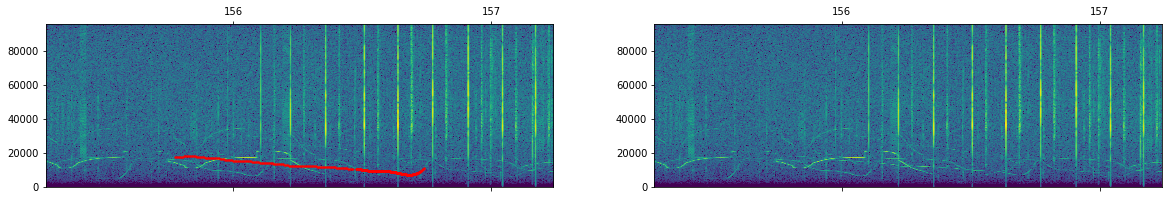

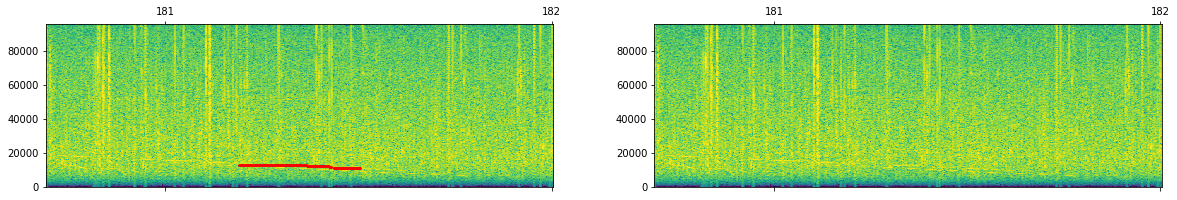

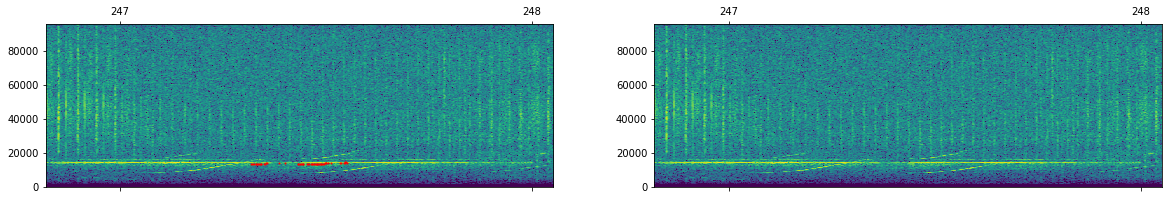

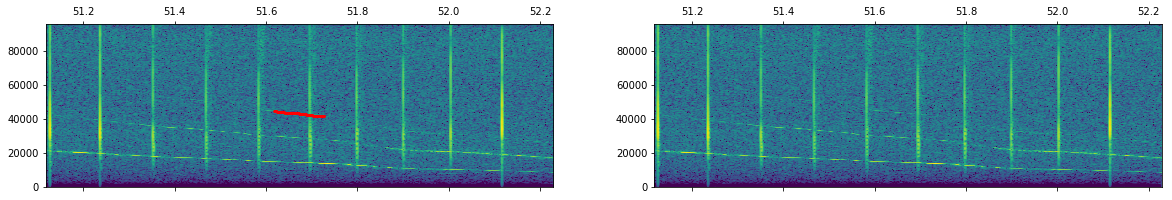

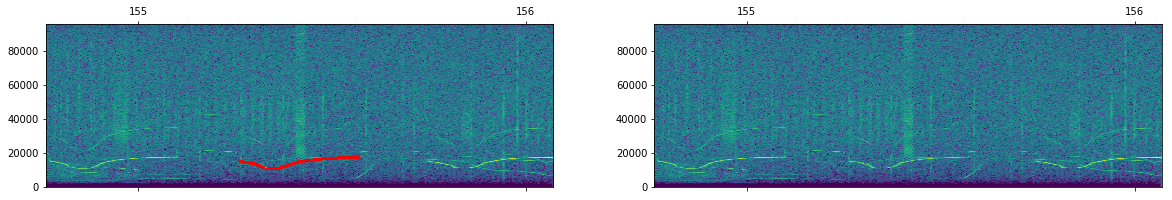

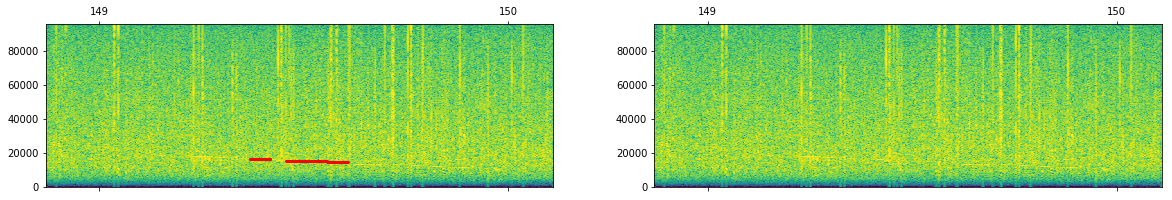

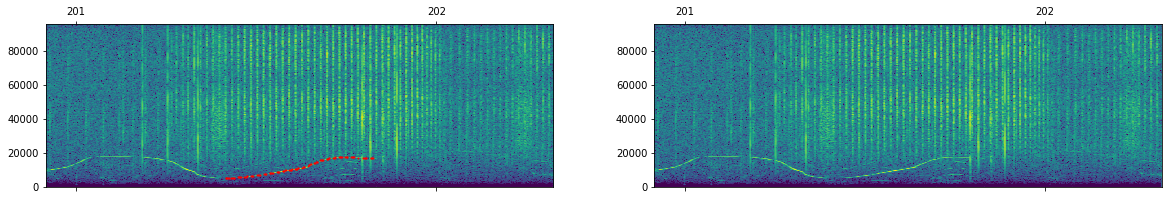

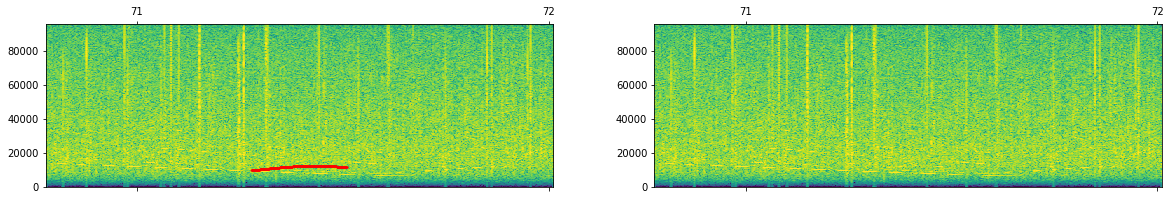

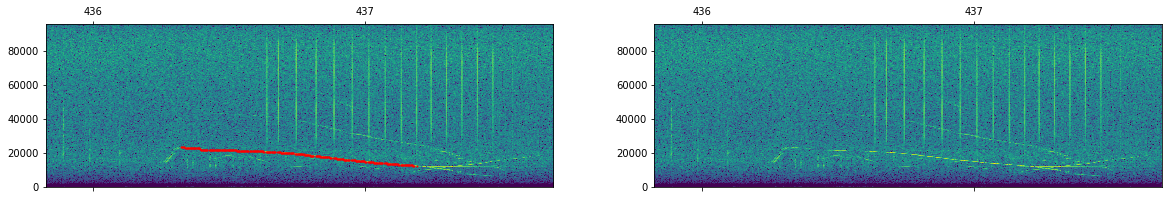

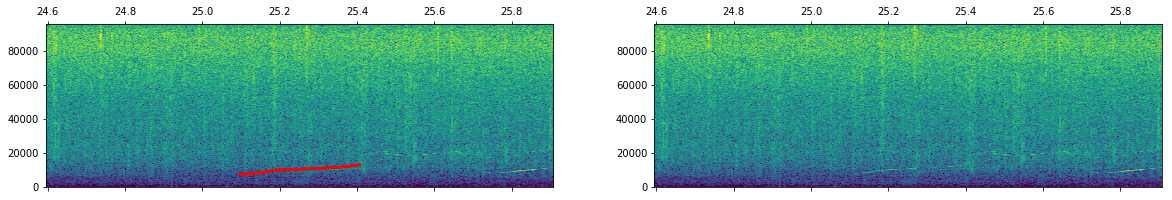

common


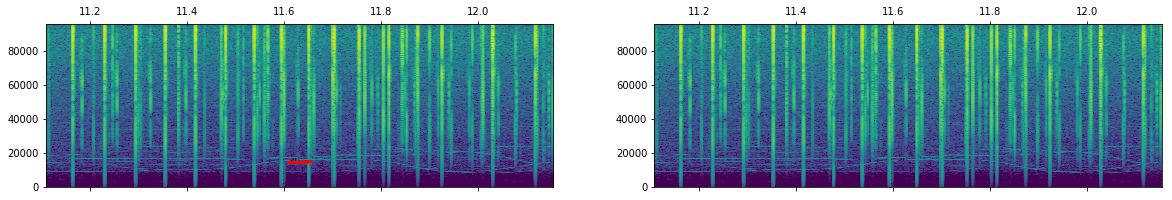

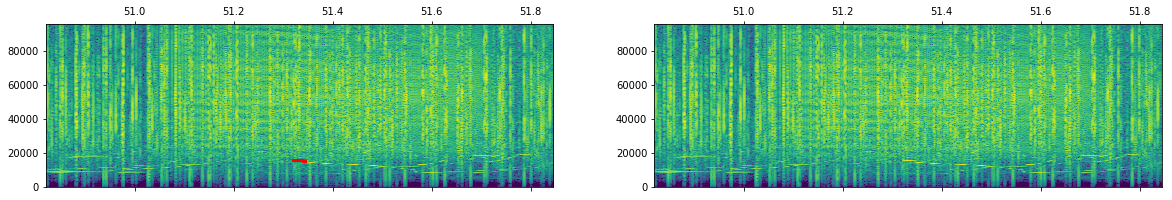

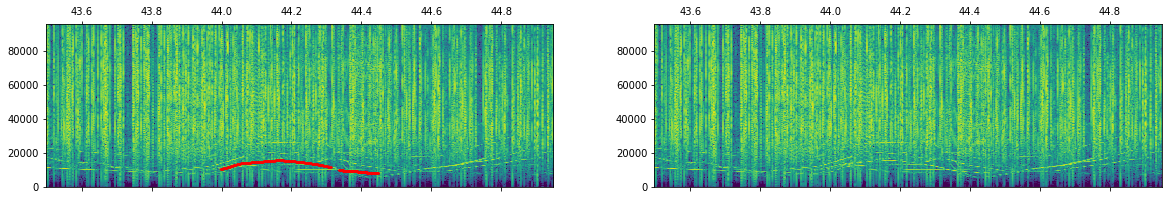

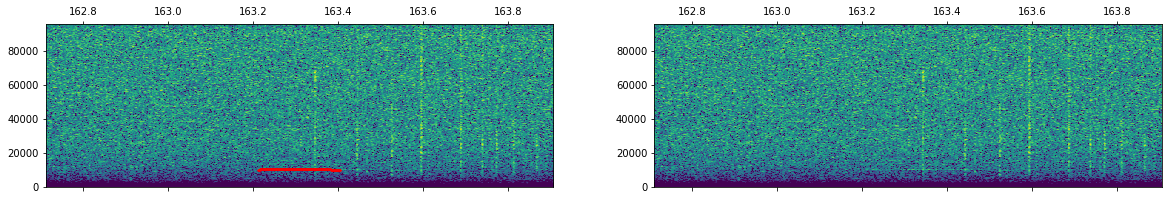

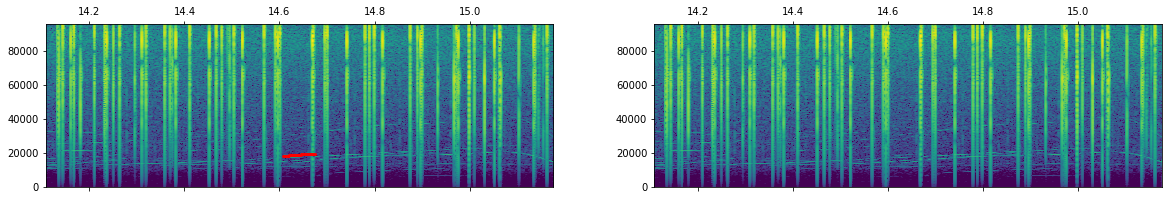

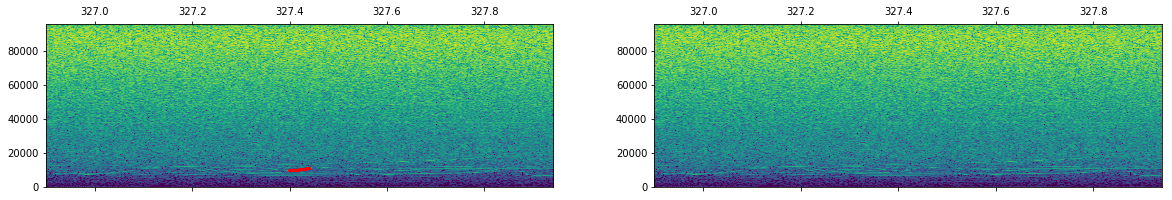

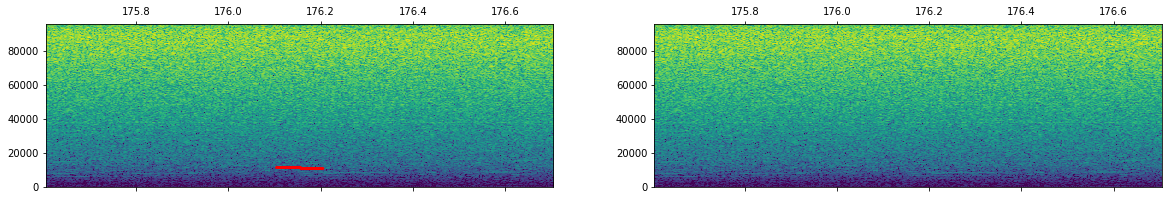

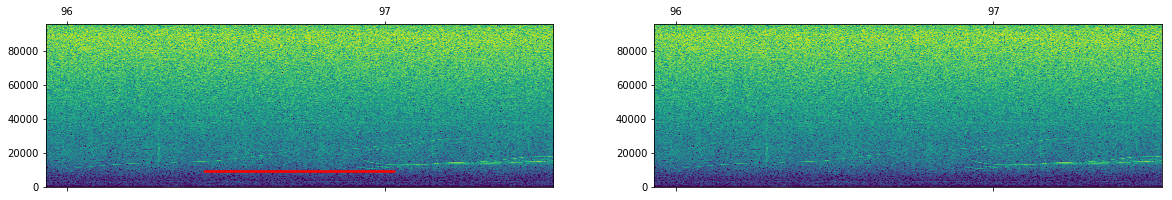

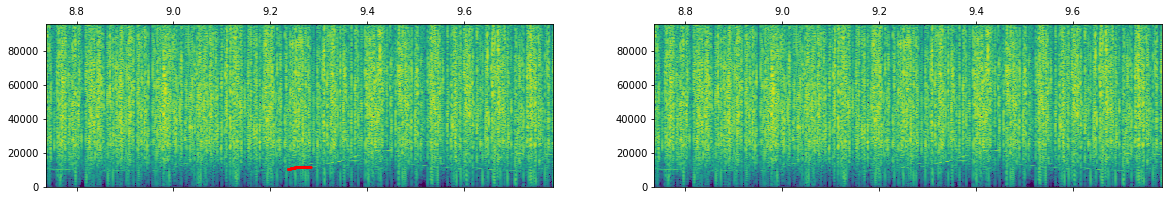

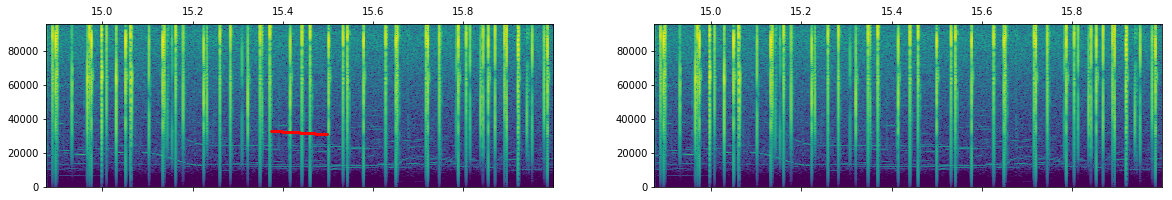

In [119]:
nex = 10
for spci, species in enumerate(tone_df.species.unique()):
    print(species)
    ax = axs.flatten()[spci]
    species_df = tone_df[tone_df.species == species]
    for ri in tqdm(range(nex), leave=False):
        row = species_df.iloc[np.random.randint(len(species_df))]
        wf = wf_df[wf_df.stem == row.stem].wf_loc.values[0]
        data, rate = librosa.core.load(
            wf,
            sr=None,
            offset=row.time[0] - time_padding,
            duration=row.duration + time_padding * 2,
        )
        spectrogram = sg.spectrogram(data, hparams)
        fig, axs = plt.subplots(ncols=2, figsize=(20, 3))
        for ax in axs.flatten():
            ax.matshow(
                spectrogram,
                origin="lower",
                aspect="auto",
                cmap=plt.cm.viridis,
                extent=[
                    row.time[0] - time_padding,
                    row.time[-1] + time_padding,
                    0,
                    rate / 2,
                ],
            )
        # ax.axis('off')
        axs[0].scatter(row.time, row.freq, s = 1, color="red")
        plt.show()

### LSTM classifier would maybe work here? 
- trim to first 1 second of whistle
